# Congenital Central Hypoventilation syndrome ("Ondine syndrome") from an existing set of genes

This notebook assumes that you have read **NORDic Network Identification (NI) Part I**. 

## Installation

In [1]:
import NORDic
! pip freeze | grep "NORDic"

-e git+https://github.com/clreda/nordic.git@859bd0341858399c88ca776d508024c9ed4c66c5#egg=NORDic


## Parameters for NORDic (from Part I)

In [2]:
file_folder="MODELS/Ondine_existing_genes/" ## the folder name is changed

Refer to Part I for further details.

In [3]:
## Registration to databases
DisGeNET_credentials = "../tests/credentials_DISGENET.txt"
STRING_credentials = "../tests/credentials_STRING.txt"
LINCS_credentials = "../tests/credentials_LINCS.txt"

## Parameters
seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2)
taxon_id=9606 # human species
disease_cids=["C1275808"] 
cell_lines=["NPC", "SHSY5Y"]

## Information about the disease
DISGENET_args = {
        "credentials": DisGeNET_credentials, "disease_cids": disease_cids,
}

## Selection of parameters relative to the prior knowledge network 
STRING_args = {
        "credentials": STRING_credentials, "score": 0,
}
EDGE_args = {
        "tau": 0, "filter": True, "connected": True, 
}

## Selection of parameters relative to experimental constraints
LINCS_args = {
        "path_to_lincs": "lincs/", "credentials": LINCS_credentials,
        "cell_lines": cell_lines, "thres_iscale": None,
}
SIG_args = {
        "bin_thres": 0.5,
}

## Selection of parameters relative to the inference of networks
BONESIS_args = {
        "limit": 1, "exact": True, "max_maxclause": 3,
}

## Advanced
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

## Using a predetermined set of genes in NORDic

The network inferred in **NORDic Network Identification (NI) Part I** might not be very interesting, due to the small number of genes. **NORDic** allows feeding an existing network to the network identification pipeline, which means that the set of genes and/or a putative prior knowledge network are provided to the pipeline.

### A. Structure of a predetermined set of genes to **NORDic**

Any gene set in input to **NORDic** is a .TXT file where each row corresponds to a single gene.

In this example, we retrieve a set of interactions from the STRING database which involve at least one gene from the network inferred in **Part I**.

In [4]:
from NORDic.UTILS.STRING_utils import get_interactions_from_STRING

with open("MODELS/Ondine/solution.bnet", "r") as f:
    gene_list = [s.split(", ")[0] for s in f.read().split("\n")]
gene_list

['ASCL1', 'BDNF', 'EDN3', 'GDNF', 'LBX1', 'PHOX2B', 'RET']

In [5]:
from subprocess import call as sbcall
sbcall("mkdir -p "+file_folder, shell=True)

## Get physical interactions from the STRING database involving the list of genes in input (strict=False)
PPI = get_interactions_from_STRING(gene_list, taxon_id, strict=False, version="11.0",
                                   min_score=0.5, app_name="NORDic_packagePartIII",file_folder=file_folder)
PPI

<STRING> Retrieving the file from STRING... Saved at MODELS/Ondine_existing_genes/protein_action_v11.0.tsv
<STRING> Getting the STRING name mapping for genes
<STRING> Getting the STRING name mapping for genes
... Protein identifier matching
... Signed
... Directed
... Aggregate info
... Solve conflicts on direction
... Solve conflicts on sign for directed edges
... Aggregate info again
... Remove multiple undirected edges
... Solve conflicts on sign for undirected edges
... Aggregate info once again


,preferredName_A,preferredName_B,sign,directed,score
0,MMP3,BDNF,2,1,0.900
1,FFAR3,EDN3,2,0,0.900
2,GNG13,EDN3,2,0,0.902
3,GDNF,SOS1,2,0,0.900
4,EDN3,AVPR1B,2,0,0.927
...,...,...,...,...,...
474,PLCG1,BDNF,1,0,0.900
475,EDN3,EDN2,2,0,0.904
476,EDN3,CASR,2,0,0.901
477,BDNF,PDGFRB,1,0,0.600


In [6]:
## Get all genes in this PPI
genes = list(set(list(PPI["preferredName_A"])+list(PPI["preferredName_B"])))
## Save that list in a .TXT file
with open(file_folder+"genes.txt", "w") as f:
    f.write("\n".join(genes))
"%d genes" % len(genes)

'287 genes'

### B. Parameter finetuning

In [7]:
STRING_args.update({"score": 0.9})
EDGE_args.update({"tau": 0.3, "filter": True, "connected": True})
SIG_args.update({"bin_thres": 0.15})
LINCS_args.update({"thres_iscale": 0})
BONESIS_args.update({"limit": 100, "exact": False, "max_maxclause": 3})

## We use the set of genes defined above
path_to_genes = file_folder+"genes.txt"

### C. Network identification using a predetermined set of genes

In [8]:
from NORDic.NORDic_NI.functions import network_identification

larger_genes = network_identification(file_folder, taxon_id, 
            path_to_genes=path_to_genes, disgenet_args=DISGENET_args, 
            string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args,
            sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY,
            seed=seed_number, network_fname=None, njobs=njobs)

--- DATA IMPORT ---
1. Import gene set from MODELS/Ondine_existing_genes/genes.txt... ... 286 genes imported.
2. Import network from STRING... ... 1885 edges in model (including 0 directed edges) with a total of 262 non-isolated genes
3. Import experiments from LINCS L1000... 
	2 cell lines are considered (['NPC', 'SHSY5Y'])
	262 genes available (convertable to EntrezIDs)
		260/262 genes retrieved in LINCS L1000
<UTILS_EXP> 0 experiments so far
	<UTILS_EXP> Duplicated treatment:CLSTN1, cell:NPC, type:trt_sh
<UTILS_EXP> 1 experiments so far
	<UTILS_EXP> Duplicated treatment:CLSTN1, cell:NPC, type:trt_sh
<UTILS_EXP> 1 experiments so far
	<UTILS_EXP> Duplicated treatment:CREB1, cell:NPC, type:trt_sh
<UTILS_EXP> 2 experiments so far
	<UTILS_EXP> Duplicated treatment:CREB1, cell:NPC, type:trt_sh
<UTILS_EXP> 2 experiments so far
	<UTILS_EXP> Duplicated treatment:CREB1, cell:NPC, type:trt_sh
<UTILS_EXP> 2 experiments so far
	<UTILS_EXP> Duplicated treatment:CRKL, cell:NPC, type:trt_sh
<UTILS_

  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

Grounding...done in 7.1s
Found 100 solutions in 108.1s (first in 15.7s; rate 1.1s)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:56<00:00, 116.25s/it]


--- SELECTION OF OPTIMAL MODEL ---
100 solutions (100 unique solutions)a topological criteria...  ...
... 100 solutions (197/214 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 13 edges
<MODEL VISUALIZATION> Maximal solution: 39 edges
          1         2         3         4         5         6         7    \
GTP  0.735362  0.741835  0.740297  0.735362  0.740297  0.735362  0.736973   

          8         9         10        11        12        13        14   \
GTP  0.735362  0.736972  0.736973  0.738543  0.741835  0.738542  0.736973   

          15        16        17        18        19        20        21   \
GTP  0.736972  0.740297  0.743334  0.741835  0.740297  0.738543  0.740072   

          22        23        24        25        26        27        28   \
GTP  0.738543  0.743334  0.741835  0.736973  0.765208  0.740297  0.736973   

          29        30        31        32        33        34        35   \
GTP  0.735362  0.743335  0.736973  0.738543  0.73

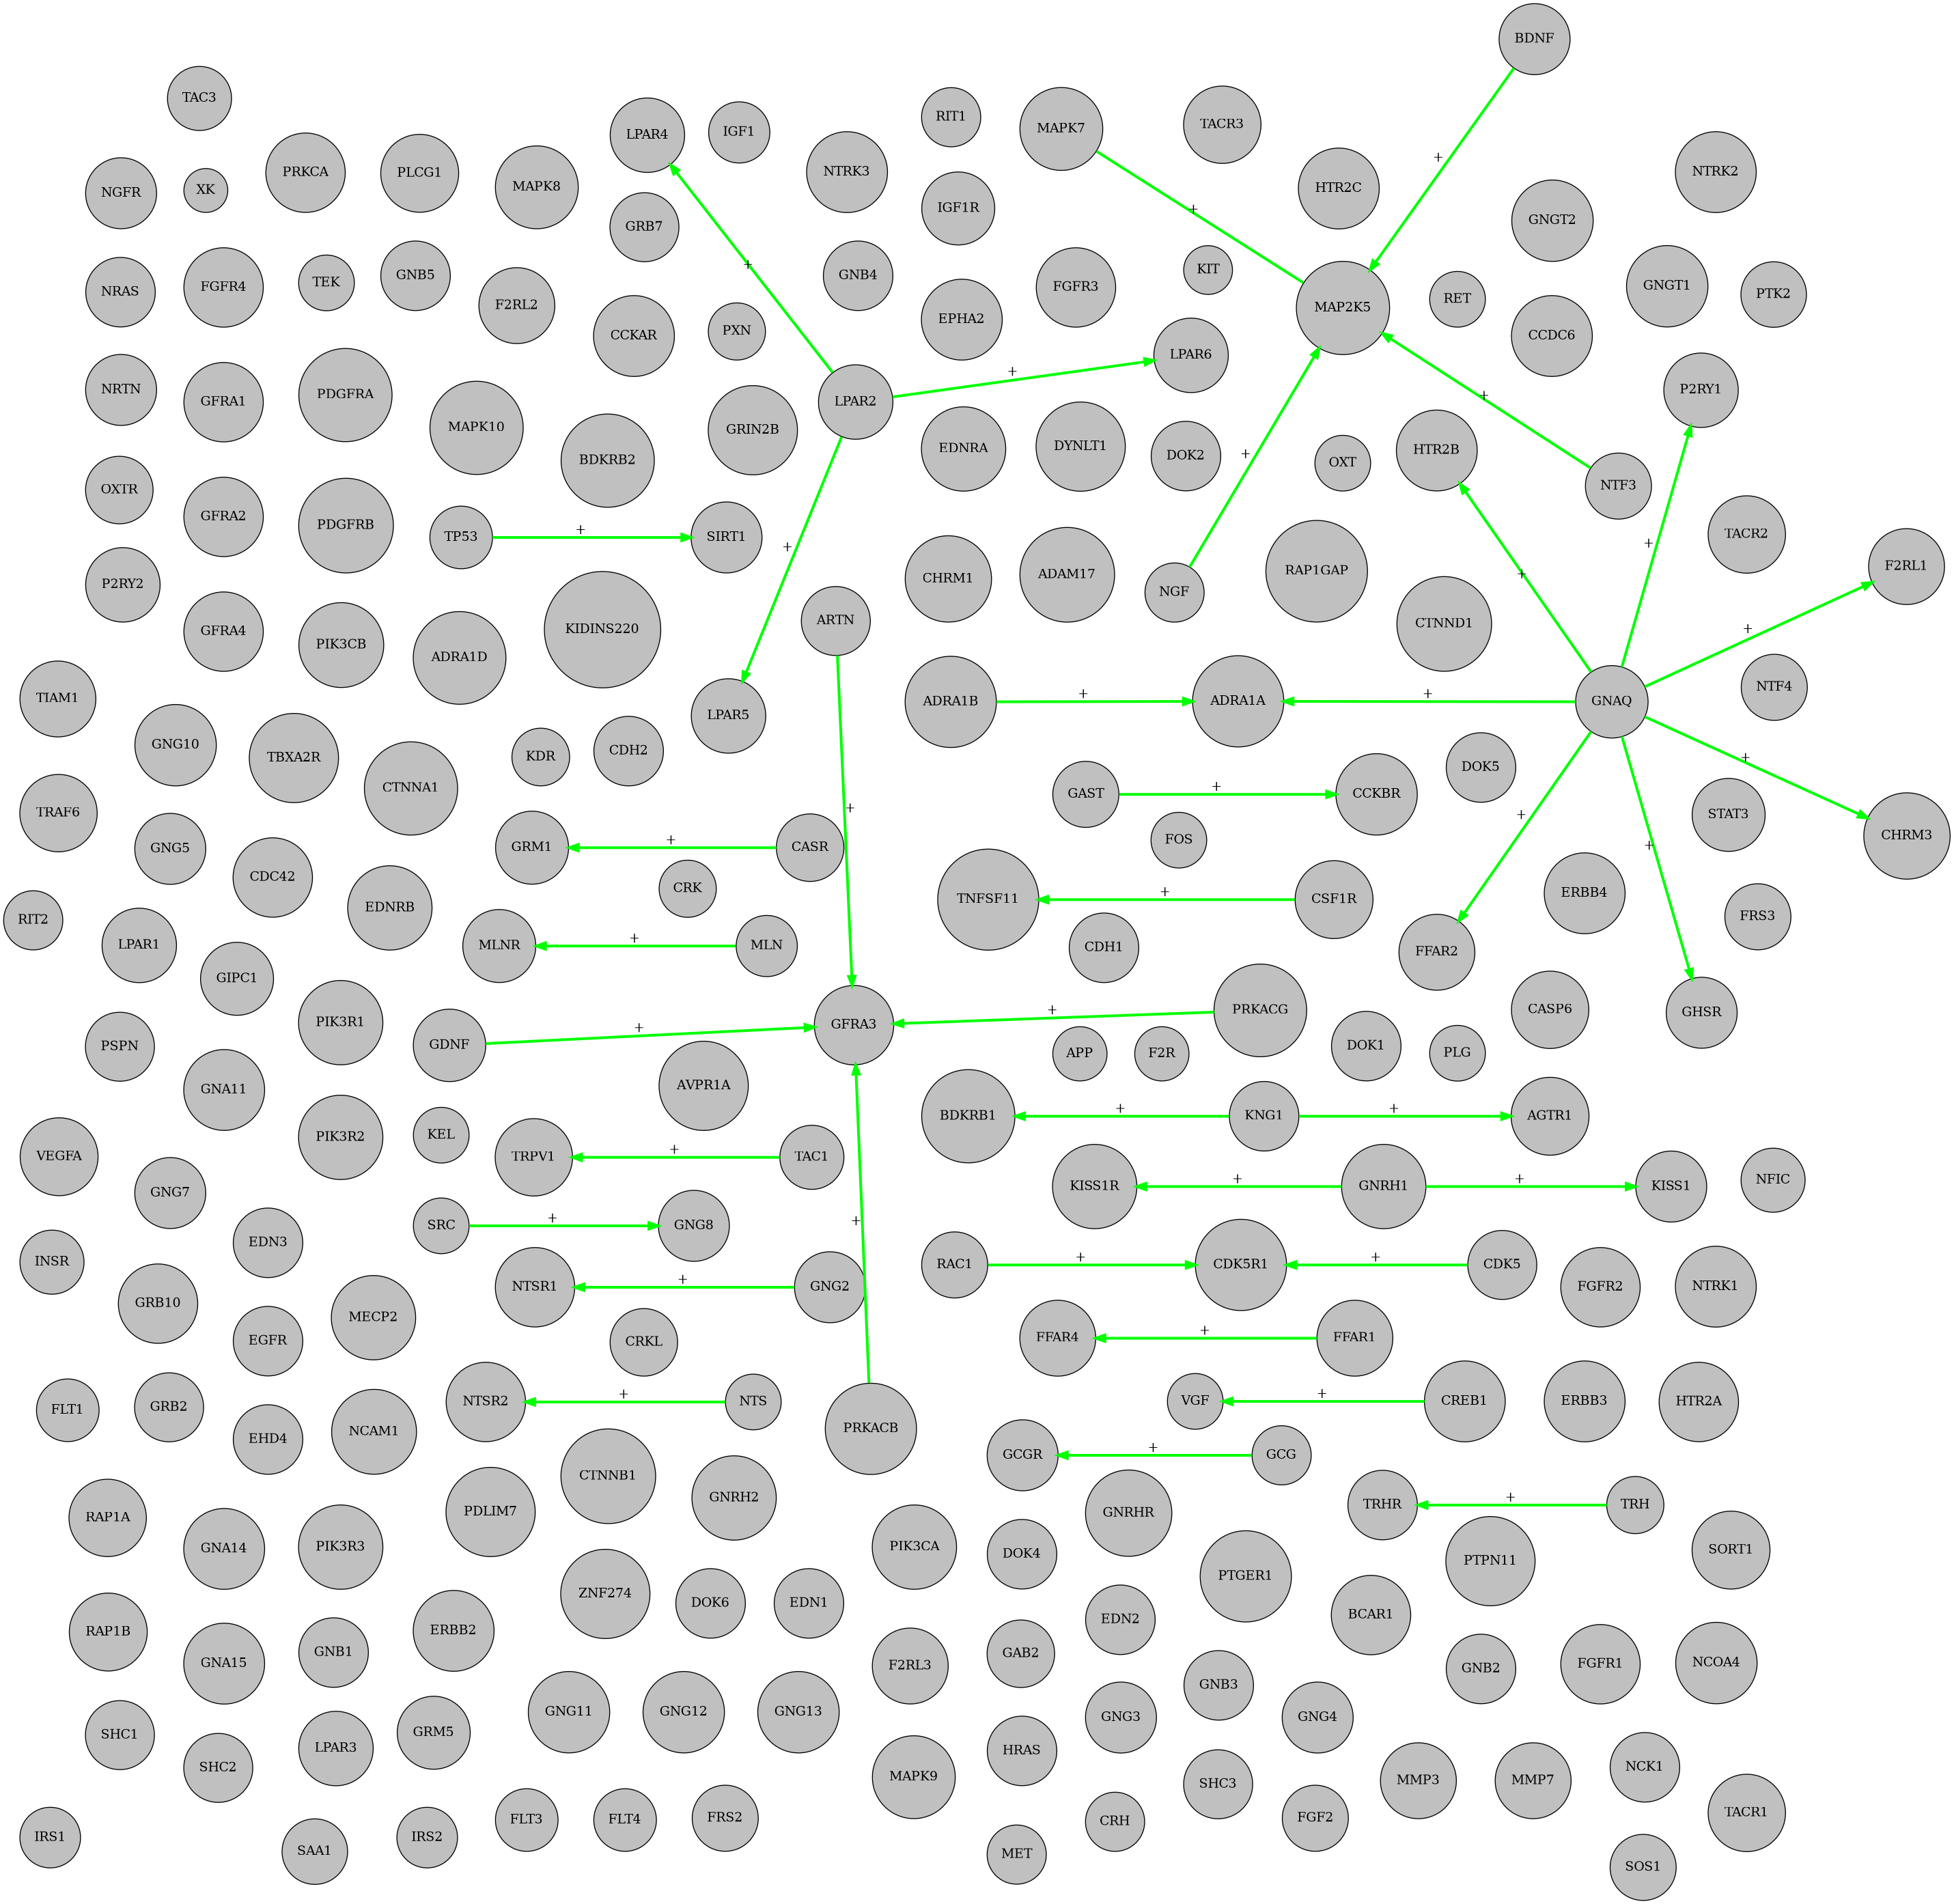

In [9]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

### D. Conclusion

Note that **NORDic** can receive as inputs both a predetermined gene set (a value of *path_to_genes* not equal to None) and a pre-existing network (a value of *network_fname* not equal to None). In that case, genes in the network will be considered, and those in the gene set will be ignored.